### 1. 데이터 분석 및 전처리

##### 1-1. 라이브러리/데이터 불러오기

In [3]:
# 필요한 라이브러리 불러오기
import matplotlib.pyplot as plt
%matplotlib inline 
# 위 코드가 없으면 plt가 안그려지니 주의하자!
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz
import seaborn as sns
from IPython.display import Image
import pydotplus
import pandas as pd
import numpy as np
import os
from pandas_profiling import ProfileReport

In [4]:
# 데이터 불러오기
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/dataset/pasteurizer.csv')
df.head(10)

Mounted at /content/drive


,STD_DT,MIXA_PASTEUR_STATE,MIXB_PASTEUR_STATE,MIXA_PASTEUR_TEMP,MIXB_PASTEUR_TEMP,INSP
0,2020-03-04 6:00,1.0,1.0,551.0,524.0,OK
1,2020-03-04 6:30,1.0,1.0,584.0,536.0,OK
2,2020-03-04 7:00,1.0,1.0,584.0,536.0,OK
3,2020-03-04 7:30,1.0,1.0,585.0,536.0,OK
4,2020-03-04 8:00,1.0,1.0,585.0,536.0,OK
5,2020-03-04 8:30,1.0,1.0,585.0,536.0,OK
6,2020-03-04 9:00,1.0,1.0,585.0,537.0,OK
7,2020-03-04 9:30,1.0,1.0,585.0,538.0,OK
8,2020-03-04 10:00,1.0,1.0,585.0,541.0,OK
9,2020-03-04 10:30,1.0,1.0,585.0,543.0,OK


##### 1-2. 데이터 종류 및 개수 확인

In [6]:
column = df.columns # 칼럼명 확인
print("📌info")
df.info() # 데이터 정보 확인
describe = df.describe() # 요약 통계량 확인
shape = df.shape # 데이터 개수 확인 (행, 열)
INSP = df['INSP'].value_counts() # INSP 칼럼의 데이터 개수 확인
null_count = df.isna().sum() # 칼럼별 null 개수 확인

print("\n📌column\n", column,"\n")
print("📌describe\n", describe,"\n")
print("📌shape\n", shape,"\n")
print("📌INSP\n", INSP,"\n")
print("📌null_count\n", null_count,"\n")

📌info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210794 entries, 0 to 210793
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   STD_DT              210794 non-null  object 
 1   MIXA_PASTEUR_STATE  11135 non-null   float64
 2   MIXB_PASTEUR_STATE  10255 non-null   float64
 3   MIXA_PASTEUR_TEMP   201423 non-null  float64
 4   MIXB_PASTEUR_TEMP   198802 non-null  float64
 5   INSP                210794 non-null  object 
dtypes: float64(4), object(2)
memory usage: 9.6+ MB

📌column
 Index(['STD_DT', 'MIXA_PASTEUR_STATE', 'MIXB_PASTEUR_STATE',
       'MIXA_PASTEUR_TEMP', 'MIXB_PASTEUR_TEMP', 'INSP'],
      dtype='object') 

📌describe
        MIXA_PASTEUR_STATE  MIXB_PASTEUR_STATE  MIXA_PASTEUR_TEMP  \
count        1.113500e+04        10255.000000      201423.000000   
mean         5.032693e+04          633.200390         566.867528   
std          5.286901e+05         6408.270847          69.061703

##### 1-3. 데이터 정제(전처리)

In [7]:
# 결측치 제거 -> null 값이 있는 행 삭제
df = df.dropna()

In [8]:
# 결측치 제거 결과 확인
df.isna().sum() 

STD_DT                0
MIXA_PASTEUR_STATE    0
MIXB_PASTEUR_STATE    0
MIXA_PASTEUR_TEMP     0
MIXB_PASTEUR_TEMP     0
INSP                  0
dtype: int64

In [9]:
# 히스토그램 확인 -> 데이터의 분포, 중심 경향, 치우침 정도 파악
plt.hist(df['MIXA_PASTEUR_STATE']) 

(array([9383.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         100.]),
 array([      0. ,  560384.1, 1120768.2, 1681152.3, 2241536.4, 2801920.5,
        3362304.6, 3922688.7, 4483072.8, 5043456.9, 5603841. ]),
 <BarContainer object of 10 artists>)

In [10]:
# 특정 칼럼의 unique 값 확인 -> 결과: 1, 5603841, 0
df['MIXA_PASTEUR_STATE'].unique()

array([1.000000e+00, 5.603841e+06, 0.000000e+00])

In [11]:
# 특정 조건의 값 변경 -> 위에서 0,1인 행만 유지하기 위해 2 이하인 값들에 대해서만 다시 df에 넣는다.
df = df[df.MIXA_PASTEUR_STATE < 2]

In [12]:
# 다른 모든 칼럼의 히스토그램 확인
plt.hist(df['MIXA_PASTEUR_STATE']) 
plt.show()
plt.hist(df['MIXB_PASTEUR_STATE'])
plt.show()
plt.hist(df['MIXA_PASTEUR_TEMP'])
plt.show()
plt.hist(df['MIXB_PASTEUR_TEMP'])  
plt.show()
plt.hist(df['INSP'])
plt.show()

##### 1-4. 데이터 특성 파악

In [13]:
# 요약 통계
df.hist(bins=10, figsize=(15,10))

array([[<AxesSubplot:title={'center':'MIXA_PASTEUR_STATE'}>,
        <AxesSubplot:title={'center':'MIXB_PASTEUR_STATE'}>],
       [<AxesSubplot:title={'center':'MIXA_PASTEUR_TEMP'}>,
        <AxesSubplot:title={'center':'MIXB_PASTEUR_TEMP'}>]], dtype=object)

In [14]:
# 특성 간의 상관관계
df.corr()

,MIXA_PASTEUR_STATE,MIXB_PASTEUR_STATE,MIXA_PASTEUR_TEMP,MIXB_PASTEUR_TEMP
MIXA_PASTEUR_STATE,1.000000,1.000000,0.523328,0.465706
MIXB_PASTEUR_STATE,1.000000,1.000000,0.523328,0.465706
MIXA_PASTEUR_TEMP,0.523328,0.523328,1.000000,0.920102
MIXB_PASTEUR_TEMP,0.465706,0.465706,0.920102,1.000000


In [15]:
# 히트맵
names = ['MIXA_PASTEUR_STATE', 'MIXB_PASTEUR_STATE', 'MIXA_PASTEUR_TEMP', 'MIXB_PASTEUR_TEMP']
cm = np.corrcoef(df[names].values.T)
sns.set(font_scale=0.6)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
            annot_kws={'size':15}, yticklabels=names, xticklabels=names)

<AxesSubplot:title={'center':'MIXB_PASTEUR_TEMP'}>

In [16]:
# 산점도 매트릭스
y = df.iloc[:, -1:].values
y = np.where(y=='OK',1,0)
y = y.ravel()
pd.plotting.scatter_matrix(df, c=y, figsize=(15,15), marker='o',
                           hist_kwds={'bins':20}, s=60, alpha=.8, cmap=plt.cm.Set1)
plt.show()

>  ▶ 양품: 회색<br>
▶ 불량: 빨간색<br>
<MIXA_PASTEUR_TEMP와 MIXB_PASTEUR_TEMP의 분포> <br>
- 특성들 간의 상관관계가 높다.
- 양품인 경우: 가운데에 위치.
- 불량인 경우: 우측 상단과 ㄴ자 모형으로 패턴 이룸. 

### 2. 모델 학습 및 성능 평가 

##### (공통) 학습/평가 데이터 분리

In [17]:
# 측정 데이터와 레이블(정답) 분리리
X = df.iloc[:, 1:5].values
y = df.iloc[:, -1:].values
y = np.where(y =='OK',1,0)
y = y.ravel() # 레이블을 1차원으로 변경함.
print(X.shape, y.shape)

(9383, 4) (9383,)


In [18]:
# 훈련셋과 테스트셋 분리
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=1)

In [19]:
print(len(y_train[y_train == 1]))
print(len(y_train[y_train == 0]))
print(len(y_test[y_test == 1]))
print(len(y_test[y_test == 0]))

5586
982
2382
433


##### (공통) 모델 성능 평가 - 1) 분류성능평가지표

> 정량평가: 오차행렬, 정확도, 정밀도, 재현율, F1 score, AUC 살펴보기

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

In [21]:
def get_clf_eval(y_test=None, pred=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  roc_auc = roc_auc_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  print('정확도: {0: .4f}, 정밀도: {1: .4f}, 재현율: {2: .4f}, F1: {3: .4f}, AUC:{4: .4f}'.format(accuracy, precision, recall, f1, roc_auc))

> 정성평가: 그래프 살펴보기

In [22]:
import matplotlib.pyplot as plt
def draw_graph(y_test=None, pred=None):
  plt.figure(figsize=(40, 9))
  plt.plot(y_test, 'b', label = 'actual')
  plt.plot(pred, 'r', label = 'prediction')
  plt.legend()
  plt.show()

  # 따로 보기
  # plt.figure(figsize = (30,6)) # Plotting
  # plt.plot(y_test, 'b', label = 'actual')
  # plt.legend()
  # plt.show()
  # plt.figure(figsize=(30, 6))
  # plt.plot(pred, 'r', label = 'prediction')
  # plt.legend()
  # plt.show()

##### (공통) 모델 성능 평가 -2) ROC curve와 case별로 살펴보기 

In [23]:
def get_eval_2(y_test=None, pred=None):
  confusion = confusion_matrix(y_test, pred)
  TN = confusion[0][0]
  FP = confusion[0][1]
  FN = confusion[1][0]
  TP = confusion[1][1]
  print("📌실제 불량일 때 불량으로 판별할 확률\n= P(실제불량)∩P(에측불량)/P(실제불량): {:.4f}".format(TN/(TN+FP)))
  #print("📌실제 불량일 때 양품으로 판별할 확률\n= P(실제불량)∩P(에측양품)/P(실제불량): {:.4f}".format(FP/(TN+FP)))
  #print("📌실제 양품일 때 불량으로 판별할 확률\n= P(실제양품)∩P(에측불량)/P(실제양품): {:.4f}".format(FN/(FN+TP)))
  print("📌실제 양품일 때 양품으로 판별할 확률\n= P(실제양품)∩P(에측양품)/P(실제양품): {:.4f}".format(TP/(FN+TP)))

  roc_auc = roc_auc_score(y_test, pred)
  print('ROC_AUC:{:.4f}'.format(roc_auc))
  return(TN/(TN+FP),TP/(FN+TP),roc_auc)

##### 2-1. 의사결정트리

In [135]:
depth = 12 # 변경해보기
dt_clf = DecisionTreeClassifier(max_depth = depth) # 의사결정트리 알고리즘 불러오기
dt_clf = dt_clf.fit(X_train, y_train) # 모델에 데이터 학습시키기
dt_prediction = dt_clf.predict(X_test) # 데이터 예측하기
# 성능평가
get_clf_eval(y_test, dt_prediction)
get_eval_2(y_test, dt_prediction)

오차 행렬
[[ 429    4]
 [   5 2377]]
정확도:  0.9968, 정밀도:  0.9983, 재현율:  0.9979, F1:  0.9981, AUC: 0.9943
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9908
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9979
ROC_AUC:0.9943


(0.9907621247113164, 0.9979009235936188, 0.9943315241524676)

In [131]:
Pa_arr = []
Pd_arr = []
Proc_arr = []
for d in range(3,101):
  dt_clf = DecisionTreeClassifier(max_depth = d) # 의사결정트리 알고리즘 불러오기
  dt_clf = dt_clf.fit(X_train, y_train) # 모델에 데이터 학습시키기
  dt_prediction = dt_clf.predict(X_test) # 데이터 예측하기
  # 성능평가
  print("---------------------depth가",d,"일 때-----------------------")
  get_clf_eval(y_test, dt_prediction)
  Pa, Pd, Proc = get_eval_2(y_test, dt_prediction)
  Pa_arr.append(Pa)
  Pd_arr.append(Pd)
  Proc_arr.append(Proc)

---------------------depth가 3 일 때-----------------------
오차 행렬
[[ 237  196]
 [   1 2381]]
정확도:  0.9300, 정밀도:  0.9239, 재현율:  0.9996, F1:  0.9603, AUC: 0.7735
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.5473
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9996
ROC_AUC:0.7735
---------------------depth가 4 일 때-----------------------
오차 행렬
[[ 238  195]
 [   1 2381]]
정확도:  0.9304, 정밀도:  0.9243, 재현율:  0.9996, F1:  0.9605, AUC: 0.7746
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.5497
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9996
ROC_AUC:0.7746
---------------------depth가 5 일 때-----------------------
오차 행렬
[[ 423   10]
 [  19 2363]]
정확도:  0.9897, 정밀도:  0.9958, 재현율:  0.9920, F1:  0.9939, AUC: 0.9845
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9769
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9920
ROC_AUC:0.9845
---------------------depth가 6 일 때-----------------------
오차 행렬
[[ 424    9]
 [  16 2366]]
정확도:  0.9911, 정밀도:  0.9962, 재현율:  0.9933, F1:  0.9947, AUC

In [119]:
print(Pa_arr)
print(Pd_arr)
print(Proc_arr)

[0.5473441108545035, 0.5496535796766744, 0.976905311778291, 0.9792147806004619, 0.976905311778291, 0.9838337182448037, 0.9861431870669746, 0.9884526558891455, 0.9884526558891455, 0.9907621247113164, 0.9907621247113164, 0.9884526558891455, 0.9907621247113164, 0.9907621247113164, 0.9907621247113164, 0.9884526558891455, 0.9884526558891455, 0.9907621247113164, 0.9884526558891455, 0.9907621247113164, 0.9884526558891455, 0.9884526558891455, 0.9907621247113164, 0.9884526558891455, 0.9884526558891455, 0.9884526558891455, 0.9884526558891455]
[0.9995801847187238, 0.9995801847187238, 0.9920235096557515, 0.9932829554995802, 0.9970612930310663, 0.9962216624685138, 0.9979009235936188, 0.9974811083123426, 0.9974811083123426, 0.9979009235936188, 0.9979009235936188, 0.9974811083123426, 0.9979009235936188, 0.9979009235936188, 0.9979009235936188, 0.9974811083123426, 0.9974811083123426, 0.9979009235936188, 0.9974811083123426, 0.9979009235936188, 0.9974811083123426, 0.9974811083123426, 0.9979009235936188, 

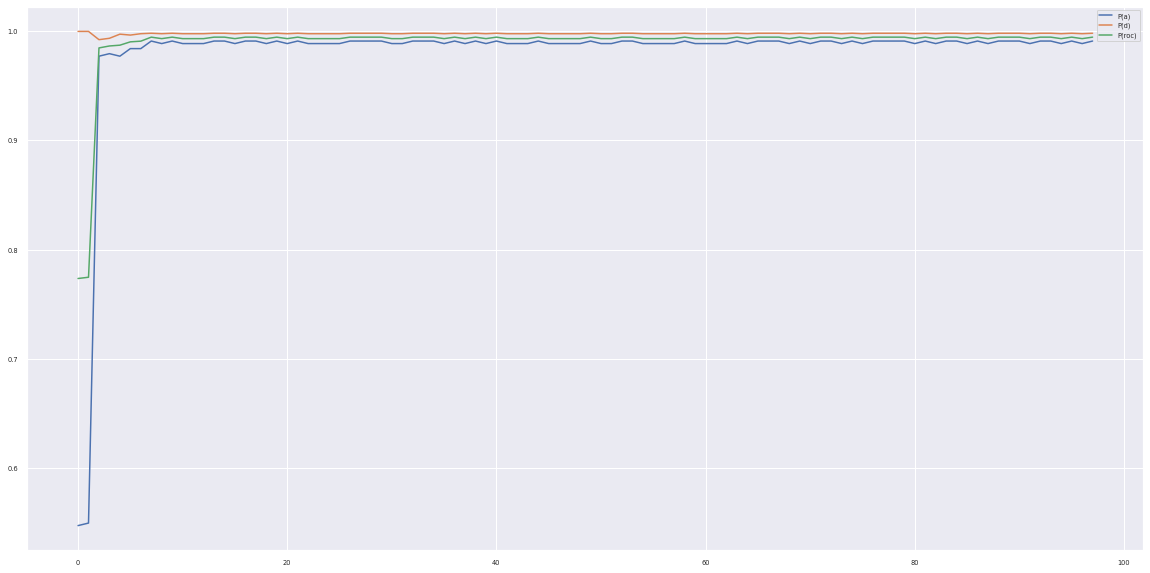

In [132]:
plt.figure(figsize=(20,10))
plt.plot(Pa_arr, label = 'P(a)')
plt.plot(Pd_arr, label = 'P(d)')
plt.plot(Proc_arr, label = 'P(roc)')
plt.legend()

In [136]:
# 시각화를 위한 사전 작업
feature_names = df.columns.tolist()
feature_names = feature_names[1:5]
target_name = np.array(['0','1'])

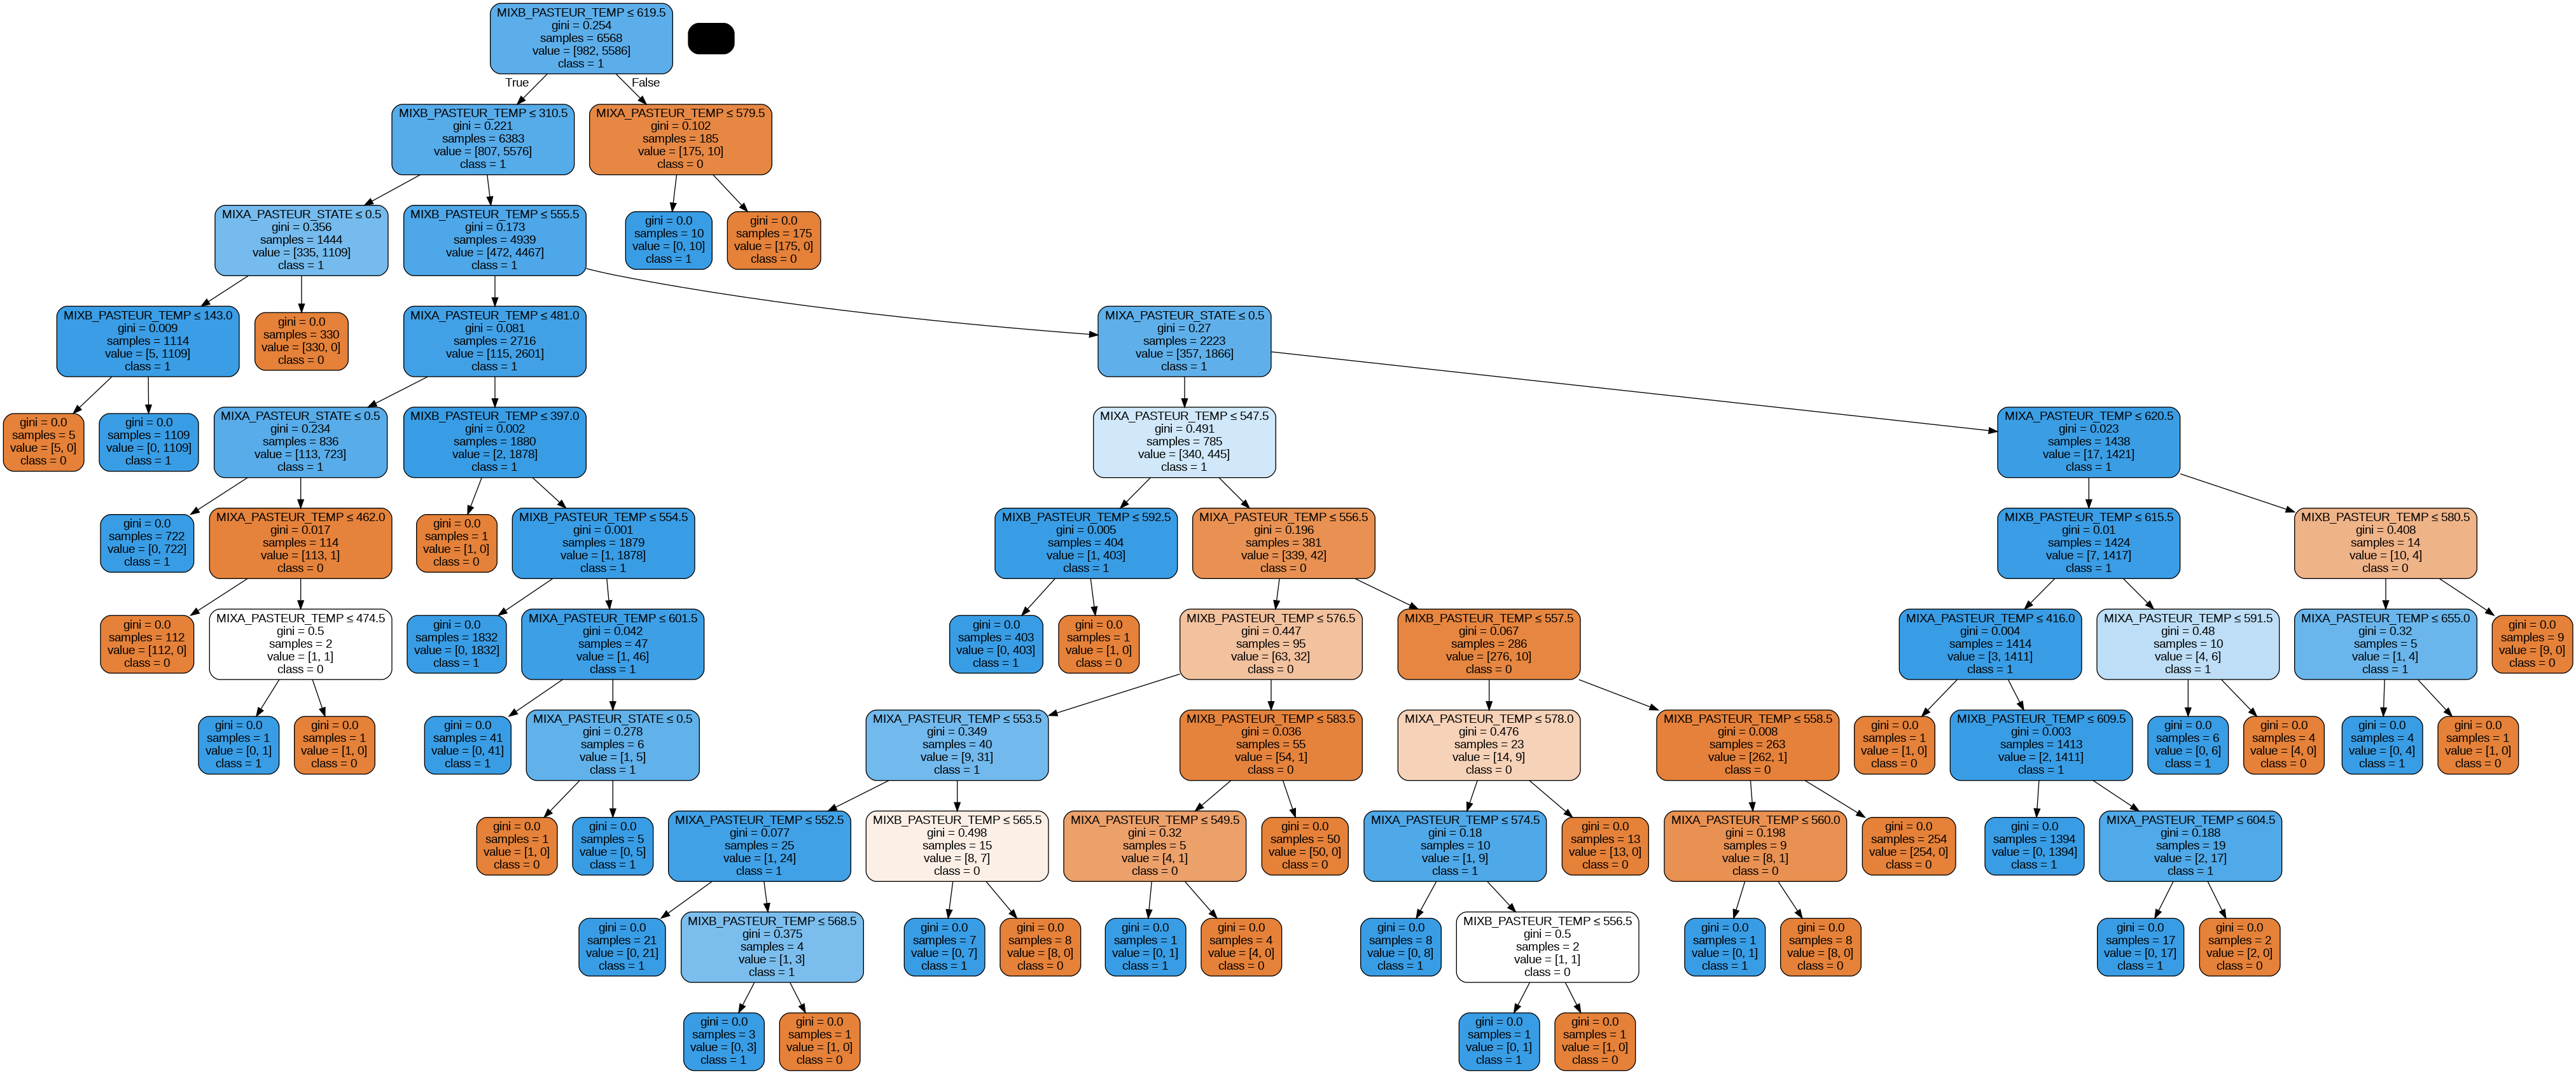

In [137]:
# Graphviz로 시각화하기
dt_dot_data = tree.export_graphviz(dt_clf,
                                   feature_names = feature_names,
                                   class_names = target_name,
                                   filled = True, rounded = True,
                                   special_characters = True)
dt_graph = pydotplus.graph_from_dot_data(dt_dot_data)
Image(dt_graph.create_png())

> 예측 결과 그래프로 보기

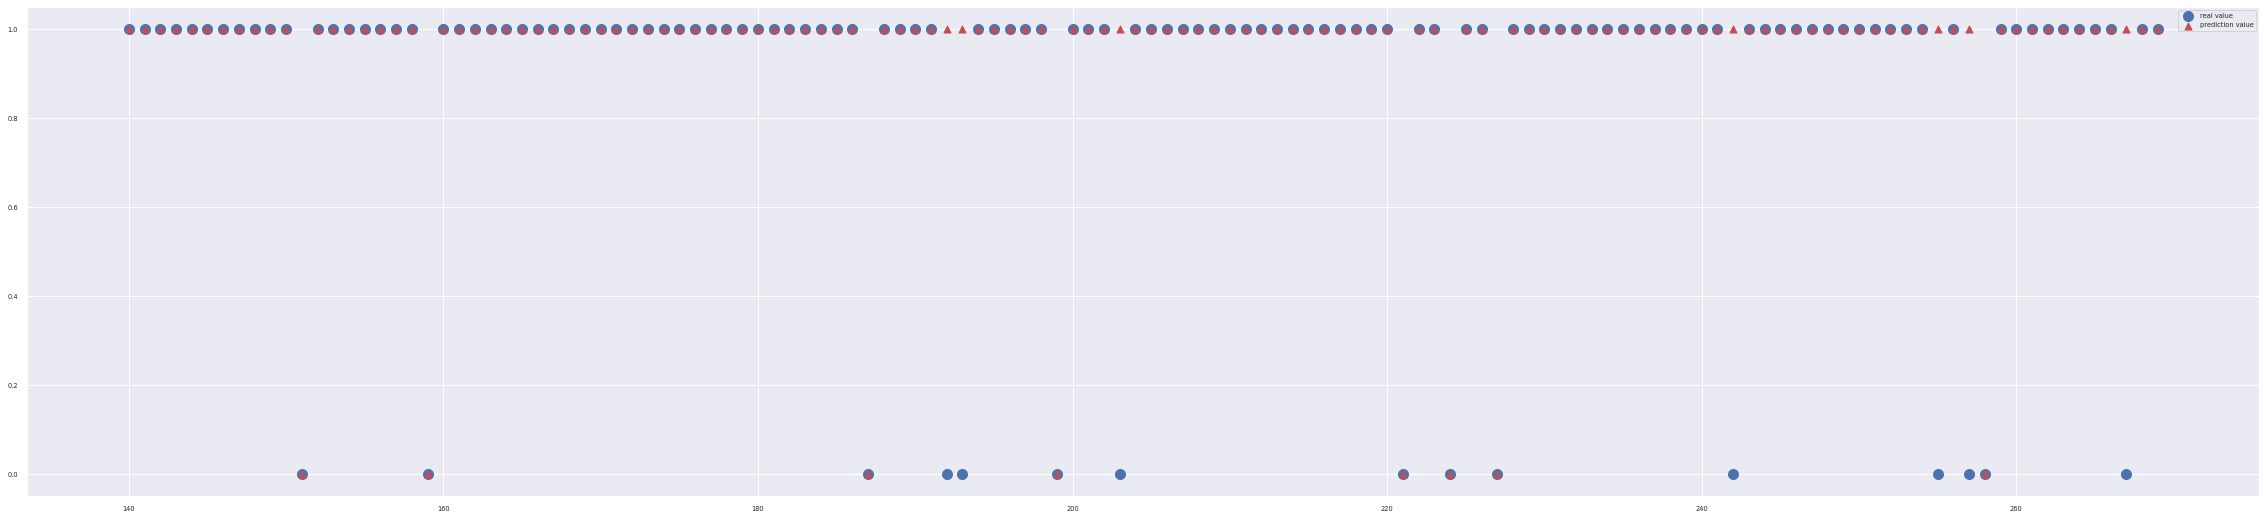

In [90]:
arr = np.array([])
for i in range(len(y_test)):
  if y_test[i]!=dt_prediction[i]:
    arr = np.append(arr, np.array([0]))
  else:
    arr = np.append(arr, np.array([1]))

fig = plt.figure(figsize=(40,9))
arr2 = np.arange(len(y_test))
plt.scatter(arr2[140:270],y_test[140:270],c='b',s=100, label="real value")
plt.scatter(arr2[140:270],dt_prediction[140:270],c='r',marker='^', s=50, label="prediction value")
plt.grid(True)
plt.legend()
    

##### 2-2. 선형 회귀

In [34]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_train, y_train)
NN = model.predict(X_test).flatten()

NN_prediction = np.array([])
for i in NN:
  if i>=0.73:
    NN_prediction = np.append(NN_prediction, np.array([1]))
  else:
    NN_prediction = np.append(NN_prediction, np.array([0]))
get_clf_eval(y_test, NN_prediction)
get_eval_2(y_test, NN_prediction)

오차 행렬
[[ 135  298]
 [  14 2368]]
정확도:  0.8892, 정밀도:  0.8882, 재현율:  0.9941, F1:  0.9382, AUC: 0.6530
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.3118
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9941
ROC_AUC:0.6530


(0.3117782909930716, 0.9941225860621327, 0.6529504385276022)

##### 2-3. 로지스틱 회귀

In [32]:
# numpy로 구현한 로지스틱 회귀 모델 학습
class logisticRegression:
  def __init__(self, lr=0.01, num_iter = 1000, fit_intercept=True, verbose = False):
    self.lr = lr
    self.num_iter = num_iter
    self.fit_intercept= fit_intercept
    self.verbose = verbose
    self.eps = 1e-10
    self.threshold = 0.5
    self.loss_history = list()

  def __add_intercept(self, X):
    intercept = np.ones((X.shape[0],1))
    return np.concatenate((intercept,X),axis=1)

  def __sigmoid(self,z):
    return 1/(1+np.exp(-z))

  def __loss(self, h, y):
    return (-y*np.log(h+self.eps)-(1-y)*np.log(1-h+self.eps)).mean()

  def fit(self, X, y):
    if self.fit_intercept:
      X = self.__add_intercept(X)

    # weights initialization
    self.theta = np.zeros(X.shape[1])

    for i in range(self.num_iter):
        logit = np.dot(X, self.theta)
        hypothesis = self.__sigmoid(logit)
        gradient = np.dot(X.T, (hypothesis - y)) / y.size
        self.theta -= self.lr*gradient

        if self.verbose == True and i%10 == 0:
          loss = self.__loss(hypothesis, y)
          print(f'epoch: {i}  loss: {loss} ')
          self.loss_history.append(loss)
    return self.loss_history

  def predict_prob(self, X):
    if self.fit_intercept:
      X = self.__add_intercept(X)
    return self.__sigmoid(np.dot(X, self.theta))

  def predict(self, X):
    predicted_labels = np.where(self.predict_prob(X) > self.threshold, 1, 0)
    return predicted_labels

model = logisticRegression(lr = 0.0001, num_iter = 100, verbose = True)
model.fit(X_train, y_train)
NN = model.predict(X_test).flatten()
print(NN)
get_clf_eval(y_test, NN)
get_eval_2(y_test, NN)

epoch: 0  loss: 0.6931471803599453 
epoch: 10  loss: 1.631648012132257 
epoch: 20  loss: 3.051254246236101 
epoch: 30  loss: 1.5186378945270542 
epoch: 40  loss: 3.2535906861973607 
epoch: 50  loss: 0.9244850888372632 
epoch: 60  loss: 1.373830957134832 
epoch: 70  loss: 3.312187223814895 
epoch: 80  loss: 1.2893939596466033 
epoch: 90  loss: 2.8028794826601287 
[1 1 1 ... 1 1 1]
오차 행렬
[[   0  433]
 [   0 2382]]
정확도:  0.8462, 정밀도:  0.8462, 재현율:  1.0000, F1:  0.9167, AUC: 0.5000
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.0000
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 1.0000
ROC_AUC:0.5000


(0.0, 1.0, 0.5)

In [36]:
# Scikit-learn 로지스틱 회귀 모델 학습
from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(X_train, y_train)
lr_model = model.predict(X_test).flatten()
get_clf_eval(y_test,lr_model)
get_eval_2(y_test, lr_model)

오차 행렬
[[  22  411]
 [   0 2382]]
정확도:  0.8540, 정밀도:  0.8528, 재현율:  1.0000, F1:  0.9206, AUC: 0.5254
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.0508
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 1.0000
ROC_AUC:0.5254


(0.050808314087759814, 1.0, 0.5254041570438799)

In [57]:
n_samples = 6568
n_classes = 2
n_sample0= 982
n_sample1= 5586
w0= n_samples/(n_classes*n_sample0)
w1= n_samples/(n_classes*n_sample1)
print(w0,w1)

3.344195519348269 0.5878983172216254


In [65]:
# Scikit-learn 로지스틱 회귀 모델 학습
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='l2',class_weight={0:w0,1:w1},C=1000, solver='liblinear', max_iter=5000).fit(X_train, y_train)
lr_model = model.predict(X_test).flatten()
get_clf_eval(y_test,lr_model)
get_eval_2(y_test, lr_model)

오차 행렬
[[ 221  212]
 [1200 1182]]
정확도:  0.4984, 정밀도:  0.8479, 재현율:  0.4962, F1:  0.6261, AUC: 0.5033
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.5104
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.4962
ROC_AUC:0.5033


(0.5103926096997691, 0.49622166246851385, 0.5033071360841415)

##### 2-6. K-근접 이웃

In [45]:
# K-neighbor
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier().fit(X_train, y_train)
knn_model = model.predict(X_test).flatten()
get_clf_eval(y_test,knn_model)
get_eval_2(y_test, knn_model)

TypeError: ignored

##### 2-4. NN(신경망)

In [ ]:
def draw_loss(history):
  history_dict = history.history
  loss = history_dict['loss']
  history_dict.keys()
  # val_loss = history_dict['val_loss']

  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, 'b', label='Training loss')  # ‘bo’는 파란색 점을 의미합니다.
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

Epoch 1/10
13/13 [==============================] - 3s 8ms/step - loss: 98.4571 - acc: 0.1489
Epoch 2/10
13/13 [==============================] - 0s 10ms/step - loss: 28.1406 - acc: 0.1625
Epoch 3/10
13/13 [==============================] - 0s 9ms/step - loss: 0.4259 - acc: 0.8876
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 0.3902 - acc: 0.8937
Epoch 5/10
13/13 [==============================] - 0s 9ms/step - loss: 0.4751 - acc: 0.8959
Epoch 6/10
13/13 [==============================] - 0s 6ms/step - loss: 0.6051 - acc: 0.8660
Epoch 7/10
13/13 [==============================] - 0s 5ms/step - loss: 0.6598 - acc: 0.8957
Epoch 8/10
13/13 [==============================] - 0s 8ms/step - loss: 0.5641 - acc: 0.8989
Epoch 9/10
13/13 [==============================] - 0s 7ms/step - loss: 0.6120 - acc: 0.8847
Epoch 10/10
88/88 [==============================] - 1s 7ms/step
오차 행렬
[[ 158  275]
 [   0 2382]]
정확도:  0.9023, 정밀도:  0.8965, 재현율:  1.0000, F1:  0.9454, AUC: 0

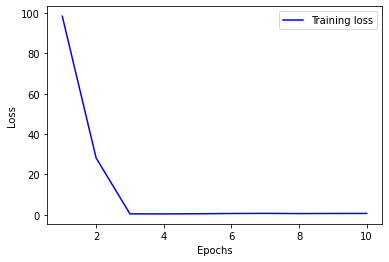

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(4, )))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) 
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=512)

NN = model.predict(X_test).flatten()

NN_prediction = np.array([])
for i in NN:
  if i>=0.5:
    NN_prediction = np.append(NN_prediction, np.array([1]))
  else:
    NN_prediction = np.append(NN_prediction, np.array([0]))

get_clf_eval(y_test, NN_prediction)
draw_loss(history)

Epoch 1/15
13/13 [==============================] - 1s 5ms/step - loss: 182.0040 - acc: 0.1488
Epoch 2/15
13/13 [==============================] - 0s 3ms/step - loss: 139.0061 - acc: 0.1488
Epoch 3/15
13/13 [==============================] - 0s 4ms/step - loss: 104.5183 - acc: 0.1488
Epoch 4/15
13/13 [==============================] - 0s 3ms/step - loss: 76.2774 - acc: 0.1488
Epoch 5/15
13/13 [==============================] - 0s 3ms/step - loss: 52.2730 - acc: 0.1488
Epoch 6/15
13/13 [==============================] - 0s 3ms/step - loss: 36.4492 - acc: 0.1488
Epoch 7/15
13/13 [==============================] - 0s 3ms/step - loss: 22.7270 - acc: 0.1488
Epoch 8/15
13/13 [==============================] - 0s 3ms/step - loss: 9.7164 - acc: 0.1488
Epoch 9/15
13/13 [==============================] - 0s 3ms/step - loss: 1.2574 - acc: 0.5501
Epoch 10/15
13/13 [==============================] - 0s 3ms/step - loss: 0.6168 - acc: 0.9007
Epoch 11/15
13/13 [==============================] - 0s 4ms

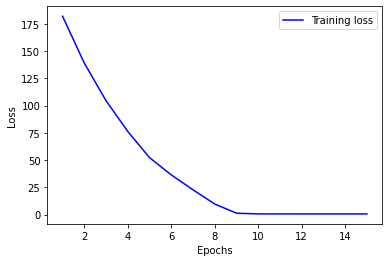

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(4, )))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) 
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, batch_size=512)

NN = model.predict(X_test).flatten()

NN_prediction = np.array([])
for i in NN:
  if i>=0.5:
    NN_prediction = np.append(NN_prediction, np.array([1]))
  else:
    NN_prediction = np.append(NN_prediction, np.array([0]))

get_clf_eval(y_test, NN_prediction)
draw_loss(history)

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(4, )))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) 
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, batch_size=512)

NN = model.predict(X_test).flatten()

NN_prediction = np.array([])
for i in NN:
  if i>=0.5:
    NN_prediction = np.append(NN_prediction, np.array([1]))
  else:
    NN_prediction = np.append(NN_prediction, np.array([0]))

get_clf_eval(y_test, NN_prediction)
draw_loss(history)

Epoch 1/15
13/13 [==============================] - 1s 5ms/step - loss: 4.0820 - acc: 0.7546
Epoch 2/15
13/13 [==============================] - 0s 5ms/step - loss: 0.7812 - acc: 0.7666
Epoch 3/15
13/13 [==============================] - 0s 6ms/step - loss: 0.5578 - acc: 0.8956
Epoch 4/15
13/13 [==============================] - 0s 5ms/step - loss: 0.4101 - acc: 0.8971
Epoch 5/15
13/13 [==============================] - 0s 6ms/step - loss: 0.3788 - acc: 0.9006
Epoch 6/15
13/13 [==============================] - 0s 7ms/step - loss: 0.3681 - acc: 0.9012
Epoch 7/15
13/13 [==============================] - 0s 6ms/step - loss: 0.3669 - acc: 0.9015
Epoch 8/15
13/13 [==============================] - 0s 5ms/step - loss: 0.3659 - acc: 0.9016
Epoch 9/15
13/13 [==============================] - 0s 8ms/step - loss: 0.3654 - acc: 0.9015
Epoch 10/15
13/13 [==============================] - 0s 6ms/step - loss: 0.3648 - acc: 0.9015
Epoch 11/15
13/13 [==============================] - 0s 5ms/step - lo

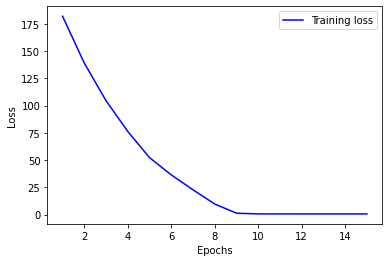

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(4, )))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) 
model.compile(optimizer='Adamax',
             loss='binary_crossentropy',
             metrics=['acc'])
model.fit(X_train, y_train, epochs=15, batch_size=512)

NN = model.predict(X_test).flatten()

NN_prediction = np.array([])
for i in NN:
  if i>=0.5:
    NN_prediction = np.append(NN_prediction, np.array([1]))
  else:
    NN_prediction = np.append(NN_prediction, np.array([0]))

get_clf_eval(y_test, NN_prediction)
draw_loss(history)

##### 2-5. XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    learning_rate=0.1,
    n_estimators = 500,
    max_depth=5,
    min_child_weight  = 3,
    gamma = 0.2,
    subsample = 0.6,
    colsample_bytree = 1.0,
    objective = 'binary:logistic',
    nthread = 4,
    scale_pos_weight = 1,
    seed = 27
)

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {
    "learning_rate": [0.1, 0.01, 0.001, 0.0001],
    "max_depth": [3,4,5,6,8,10,12,15],
    "min_child_weight":[1,3,5,7],
    "gammma":[0.0,0.1,0.2,0.3,0.4],
    "colsample_bytree":[0.3,0.4,0.5,0.7]
}

grid = GridSearchCV(xgb,
                    parameters, n_jobs = 4,
                    scoring = "neg_log_loss",
                    cv = 5)

grid.fit(
    X_train.squeeze(),
    y_train,
    eval_metric="auc",
    eval_set = [(X_train, y_train)],
    verbose = True
)


KeyboardInterrupt: ignored

In [ ]:
xgb.fit(
    X_train,
    y_train,
    eval_metric = ['auc', 'error'],
    eval_set=[(X_train, y_train)],
    verbose=True
)

##### 2-7. SVM machine